In [139]:
%load_ext autoreload
%autoreload 2

import json
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.art3d as art3d

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
with open('0021500495.json', 'r') as json_file:
    event_data = json.load(json_file)

In [3]:
def make_position_dataframe(event_data, target_team_id, target_player_id, target_event_id=None):
    
    event_df = pd.DataFrame()
    
    for event in event_data['events']:
        event_id = event['eventId']

        if target_event_id is not None and event_id != str(target_event_id):
            continue
        
        moment_df = pd.DataFrame()
        
        for moment in event['moments']:
            timestamp = moment[1]
            qtr = moment[0]
            qtr_rem = moment[2]
            shot_rem = moment[3]
            
            for player_pos_data in moment[5]:
                team_id = player_pos_data[0]
                player_id = player_pos_data[1]
                
                
                #if team_id ==target_team_id:
                    #import pdb; pdb.set_trace()
                
                if team_id==target_team_id and player_id==target_player_id:
                    
                    x = player_pos_data[2]
                    y = player_pos_data[3]
                    z = player_pos_data[4]
                    
                    row = {'eventId':event_id, 'timestamp':timestamp,
                          'qtr':qtr, 'qtr_rem':qtr_rem, 'shot_rem':shot_rem,
                          'team_id':team_id, 'player_id':player_id,
                          'x':x, 'y':y, 'z':z}
                    
                    moment_df = pd.concat([moment_df, pd.DataFrame([row])])
                    
            
        event_df = pd.concat([event_df, moment_df])
        
    return event_df

In [19]:
ball_data_crowder_ft = make_position_dataframe(event_data, -1, -1, 39)

In [20]:
rim_1_x = 5.25
rim_1_y = 25
rim_2_x = 94-5.25
rim_2_y = 25

In [21]:
def rolling_distance(frames):
    import pdb; pdb.set_trace()
    try:
        current_frame = frames['x']
        last_frame = frames['y']
    except KeyError:
        return 0
    
    return (current_frame['x']-last_frame['x'])**2 + \
           (current_frame['y']-last_frame['y'])**2 + \
           (current_frame['z']-last_frame['z'])**2

In [30]:
ball_data_crowder_ft = make_position_dataframe(event_data, -1, -1, 39)
ball_data_crowder_ft['dist_to_rim_1'] = (ball_data_crowder_ft['x'] - rim_1_x)**2 + \
                                        (ball_data_crowder_ft['y'] - rim_1_y)**2 + \
                                        (ball_data_crowder_ft['z'] - 10)**2
ball_data_crowder_ft['dist_to_rim_2'] = (ball_data_crowder_ft['x'] - rim_2_x)**2 + \
                                        (ball_data_crowder_ft['y'] - rim_2_y)**2 + \
                                        (ball_data_crowder_ft['z'] - 10)**2

ball_data_crowder_ft['avg_z'] = ball_data_crowder_ft.rolling(5, min_periods=1).mean()['z']
ball_data_crowder_ft['shot_drops'] = ball_data_crowder_ft['avg_z'].rolling(2, min_periods=2).apply(lambda x: x.values[1]<10 and x.values[0]>10)

ball_data_crowder_ft['vel_rim_1'] = ball_data_crowder_ft['dist_to_rim_1'].diff()
ball_data_crowder_ft['avg_vel_rim_1'] = ball_data_crowder_ft.rolling(5, min_periods=1).mean()['vel_rim_1']
ball_data_crowder_ft['vel_rim_2'] = ball_data_crowder_ft['dist_to_rim_2'].diff()
ball_data_crowder_ft['avg_vel_rim_2'] = ball_data_crowder_ft.rolling(5, min_periods=1).mean()['vel_rim_2']
ball_data_crowder_ft['acc_rim_1'] = ball_data_crowder_ft['vel_rim_1'].diff()
ball_data_crowder_ft['avg_acc_rim_1'] = ball_data_crowder_ft.rolling(5, min_periods=1).mean()['acc_rim_1']
ball_data_crowder_ft['acc_rim_2'] = ball_data_crowder_ft['vel_rim_2'].diff()
ball_data_crowder_ft['avg_acc_rim_1'] = ball_data_crowder_ft.rolling(5, min_periods=1).mean()['acc_rim_1']

ball_data_crowder_ft['velocity'] = ball_data_crowder_ft['x'].rolling(2,min_periods=2).apply(lambda x: (x.values[-1]-x.values[-2])**2) + \
ball_data_crowder_ft['y'].rolling(2,min_periods=2).apply(lambda x: (x.values[-1]-x.values[-2])**2) + \
ball_data_crowder_ft['z'].rolling(2,min_periods=2).apply(lambda x: (x.values[-1]-x.values[-2])**2)

In [133]:
ball_data_crowder_ft = make_position_dataframe(event_data, -1, -1, 39)


ball_data_crowder_ft['avg_x'] = ball_data_crowder_ft.rolling(20, min_periods=1).mean()['x']
ball_data_crowder_ft['avg_y'] = ball_data_crowder_ft.rolling(20, min_periods=1).mean()['y']
ball_data_crowder_ft['avg_z'] = ball_data_crowder_ft.rolling(20, min_periods=1).mean()['z']

ball_data_crowder_ft['dist_to_rim_1'] = (ball_data_crowder_ft['avg_x'] - rim_1_x)**2 + \
                                        (ball_data_crowder_ft['avg_y'] - rim_1_y)**2 
ball_data_crowder_ft['dist_to_rim_2'] = (ball_data_crowder_ft['avg_x'] - rim_2_x)**2 + \
                                        (ball_data_crowder_ft['avg_y'] - rim_2_y)**2 


ball_data_crowder_ft['shot_drops'] = ball_data_crowder_ft['avg_z'].rolling(2, min_periods=2).apply(lambda x: x.values[1]<10 and x.values[0]>10)

ball_data_crowder_ft['vel_rim_1'] = -ball_data_crowder_ft['dist_to_rim_1'].diff()
ball_data_crowder_ft['avg_vel_rim_1'] = ball_data_crowder_ft.rolling(5, min_periods=1).mean()['vel_rim_1']
ball_data_crowder_ft['vel_rim_2'] = -ball_data_crowder_ft['dist_to_rim_2'].diff()
ball_data_crowder_ft['avg_vel_rim_2'] = ball_data_crowder_ft.rolling(5, min_periods=1).mean()['vel_rim_2']
ball_data_crowder_ft['acc_rim_1'] = ball_data_crowder_ft['vel_rim_1'].diff()
ball_data_crowder_ft['avg_acc_rim_1'] = ball_data_crowder_ft.rolling(20, min_periods=1).mean()['acc_rim_1']
ball_data_crowder_ft['acc_rim_2'] = ball_data_crowder_ft['vel_rim_2'].diff()
ball_data_crowder_ft['avg_acc_rim_2'] = ball_data_crowder_ft.rolling(5, min_periods=1).mean()['acc_rim_2']

ball_data_crowder_ft['go_to_rim_1'] = ball_data_crowder_ft['avg_acc_rim_1'].rolling(2, min_periods=2).apply(lambda x: x.values[1]>0 and x.values[0]<0)
ball_data_crowder_ft['go_to_rim_2'] = ball_data_crowder_ft['avg_acc_rim_2'].rolling(2, min_periods=2).apply(lambda x: x.values[1]>0 and x.values[0]<0)


ball_data_crowder_ft['velocity'] = ball_data_crowder_ft['avg_x'].rolling(2,min_periods=2).apply(lambda x: (x.values[-1]-x.values[-2])**2) + \
ball_data_crowder_ft['avg_y'].rolling(2,min_periods=2).apply(lambda x: (x.values[-1]-x.values[-2])**2) 

(0.0, 1.0)

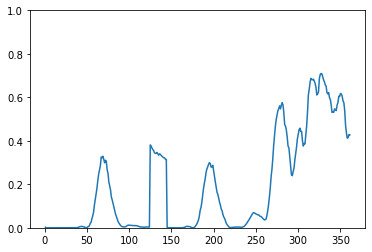

In [134]:
plt.plot(range(len(ball_data_crowder_ft)), ball_data_crowder_ft['velocity'])
plt.ylim(0,1)

(-20.0, 20.0)

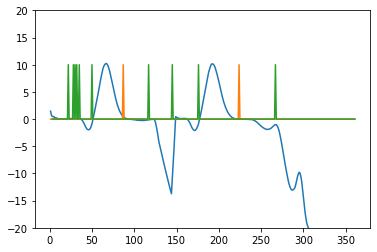

In [137]:
plt.plot(range(len(ball_data_crowder_ft)), ball_data_crowder_ft['avg_vel_rim_1'])
plt.plot(range(len(ball_data_crowder_ft)), ball_data_crowder_ft['shot_drops']*10)

plt.plot(range(len(ball_data_crowder_ft)), ball_data_crowder_ft['go_to_rim_1']*10)


plt.ylim(-20,20)

In [144]:
drop_locs = np.where(ball_data_crowder_ft['shot_drops'].values==1)[0]
rim_accels = np.where(ball_data_crowder_ft['go_to_rim_1'].values==1)[0]


for drop_location in drop_locs:
    print(max(rim_accels[rim_accels<drop_location]))
    

50
176


In [143]:
drop_locs[0]

array([ 87, 224])

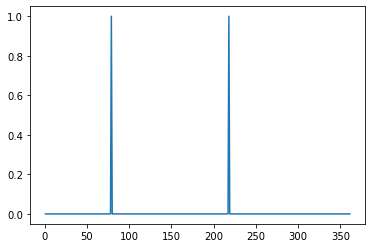

In [55]:
plt.plot(range(len(ball_data_crowder_ft)), ball_data_crowder_ft['shot_drops'])


(0.0, 100.0)

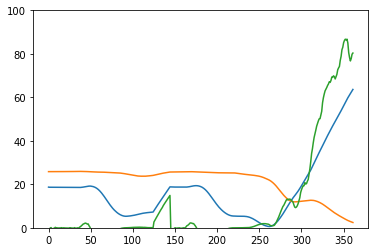

In [86]:
plt.plot(range(len(ball_data_crowder_ft)), ball_data_crowder_ft['avg_x'])
plt.plot(range(len(ball_data_crowder_ft)), ball_data_crowder_ft['avg_y'])

plt.plot(range(len(ball_data_crowder_ft)), ball_data_crowder_ft['vel_rim_1'])
plt.ylim(0,100)



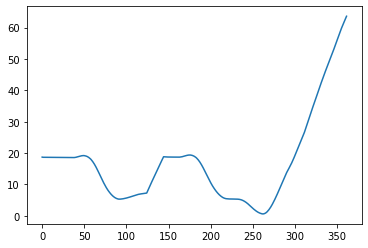

In [91]:
plt.plot(range(len(ball_data_crowder_ft)), ball_data_crowder_ft['avg_x'])

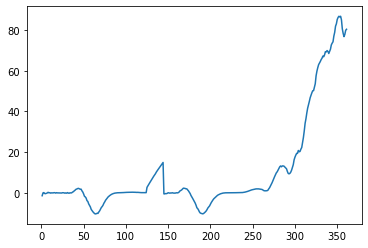

In [94]:
plt.plot(range(len(ball_data_crowder_ft)), ball_data_crowder_ft['vel_rim_1'])

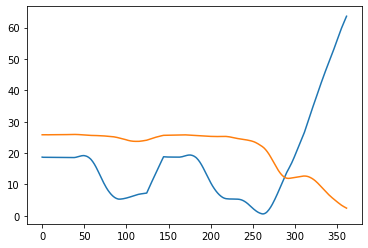

In [96]:
plt.plot(range(len(ball_data_crowder_ft)), ball_data_crowder_ft['avg_x'])
plt.plot(range(len(ball_data_crowder_ft)), ball_data_crowder_ft['avg_y'])

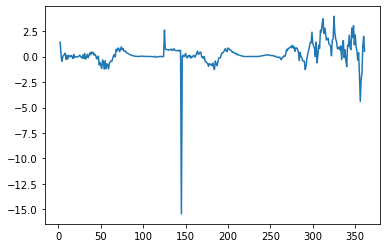

In [108]:
plt.plot(range(len(ball_data_crowder_ft)), ball_data_crowder_ft['vel_rim_1'].diff())


(0.0, 200.0)

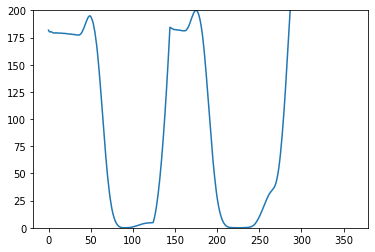

In [101]:
plt.plot(range(len(ball_data_crowder_ft)), ball_data_crowder_ft['dist_to_rim_1'])
plt.ylim(0,200)

In [103]:
ball_data_crowder_ft['dist_to_rim_1'].values[140]

128.44047189132127

In [104]:
ball_data_crowder_ft['dist_to_rim_1'].values[139]

115.88212707414121